In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [4]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [5]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [6]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 동일한 예측

0.976

## 특성 중요도

In [7]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [8]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

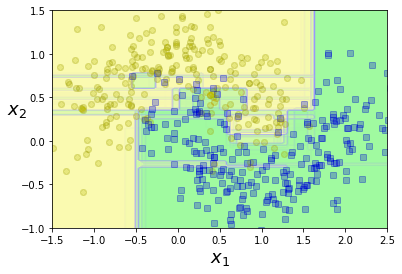

In [13]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

# 앙상블

In [8]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [16]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [17]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [18]:
X_new = np.array([[0.8]])

In [19]:
X_new

array([[0.8]])

In [20]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [21]:
y_pred

array([0.75026781])

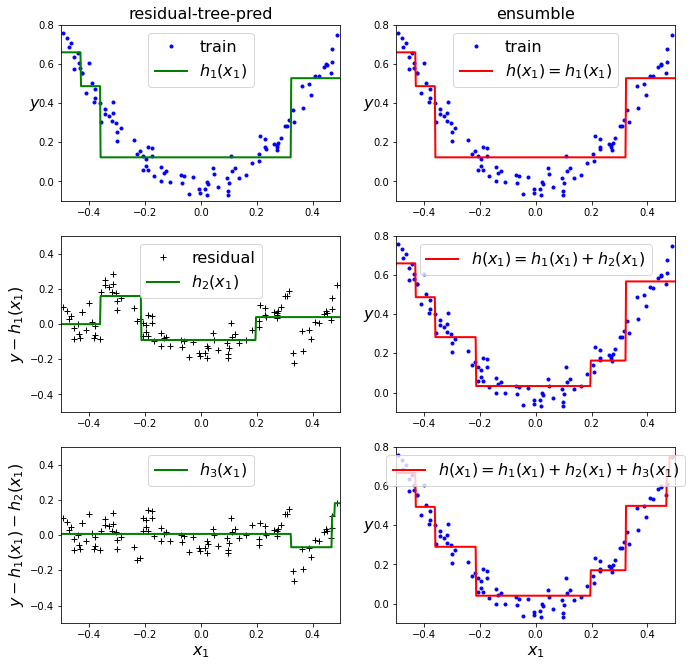

In [23]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="train")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("residual-tree-pred", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="train")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("ensumble", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="residual")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

# 차원축소

In [10]:
# pca
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

In [11]:
U

array([[-0.03231122,  0.16234339,  0.08845093, ..., -0.0144054 ,
        -0.1502582 , -0.12239577],
       [ 0.16234339,  0.97446954, -0.01390998, ...,  0.00226542,
         0.02362992,  0.01924821],
       [ 0.08845093, -0.01390998,  0.99242131, ...,  0.00123429,
         0.01287449,  0.01048717],
       ...,
       [-0.0144054 ,  0.00226542,  0.00123429, ...,  0.99979898,
        -0.00209678, -0.00170797],
       [-0.1502582 ,  0.02362992,  0.01287449, ..., -0.00209678,
         0.97812915, -0.01781533],
       [-0.12239577,  0.01924821,  0.01048717, ..., -0.00170797,
        -0.01781533,  0.98548817]])

In [12]:
s

array([2.95998227])

In [13]:
Vt

array([[1.]])

In [14]:
X.mean(axis=0)

array([-0.02981926])

In [15]:
X_centered

array([[-0.09564062],
       [ 0.48053356],
       [ 0.2618132 ],
       [ 0.12847774],
       [-0.3141621 ],
       [-0.31418622],
       [-0.41209713],
       [ 0.3959954 ],
       [ 0.13093427],
       [ 0.23789183],
       [-0.44959625],
       [ 0.49972911],
       [ 0.3622619 ],
       [-0.25784163],
       [-0.28835578],
       [-0.28677623],
       [-0.1659385 ],
       [ 0.05457569],
       [-0.03823572],
       [-0.1789516 ],
       [ 0.14167215],
       [-0.33068688],
       [-0.17803609],
       [-0.1038189 ],
       [-0.01411076],
       [ 0.31499522],
       [-0.27050696],
       [ 0.0440537 ],
       [ 0.12223383],
       [-0.42373033],
       [ 0.13736411],
       [-0.29965662],
       [-0.40512915],
       [ 0.47870479],
       [ 0.49545129],
       [ 0.3382166 ],
       [-0.16556697],
       [-0.37250863],
       [ 0.21405228],
       [-0.03002825],
       [-0.34814251],
       [ 0.02499617],
       [-0.43579222],
       [ 0.43913966],
       [-0.21140076],
       [ 0

In [16]:
X

array([[-0.12545988],
       [ 0.45071431],
       [ 0.23199394],
       [ 0.09865848],
       [-0.34398136],
       [-0.34400548],
       [-0.44191639],
       [ 0.36617615],
       [ 0.10111501],
       [ 0.20807258],
       [-0.47941551],
       [ 0.46990985],
       [ 0.33244264],
       [-0.28766089],
       [-0.31817503],
       [-0.31659549],
       [-0.19575776],
       [ 0.02475643],
       [-0.06805498],
       [-0.20877086],
       [ 0.11185289],
       [-0.36050614],
       [-0.20785535],
       [-0.13363816],
       [-0.04393002],
       [ 0.28517596],
       [-0.30032622],
       [ 0.01423444],
       [ 0.09241457],
       [-0.45354959],
       [ 0.10754485],
       [-0.32947588],
       [-0.43494841],
       [ 0.44888554],
       [ 0.46563203],
       [ 0.30839735],
       [-0.19538623],
       [-0.40232789],
       [ 0.18423303],
       [-0.05984751],
       [-0.37796177],
       [-0.00482309],
       [-0.46561148],
       [ 0.4093204 ],
       [-0.24122002],
       [ 0

In [17]:
c1 = Vt.T[:, 0]

In [18]:
c1

array([1.])

In [29]:
##PCA
from sklearn.decomposition import PCA

pca = PCA()

In [27]:
pca

PCA(n_components=2)

In [30]:
X2D = pca.fit_transform(X)

In [31]:
X2D

array([[-0.09564062],
       [ 0.48053356],
       [ 0.2618132 ],
       [ 0.12847774],
       [-0.3141621 ],
       [-0.31418622],
       [-0.41209713],
       [ 0.3959954 ],
       [ 0.13093427],
       [ 0.23789183],
       [-0.44959625],
       [ 0.49972911],
       [ 0.3622619 ],
       [-0.25784163],
       [-0.28835578],
       [-0.28677623],
       [-0.1659385 ],
       [ 0.05457569],
       [-0.03823572],
       [-0.1789516 ],
       [ 0.14167215],
       [-0.33068688],
       [-0.17803609],
       [-0.1038189 ],
       [-0.01411076],
       [ 0.31499522],
       [-0.27050696],
       [ 0.0440537 ],
       [ 0.12223383],
       [-0.42373033],
       [ 0.13736411],
       [-0.29965662],
       [-0.40512915],
       [ 0.47870479],
       [ 0.49545129],
       [ 0.3382166 ],
       [-0.16556697],
       [-0.37250863],
       [ 0.21405228],
       [-0.03002825],
       [-0.34814251],
       [ 0.02499617],
       [-0.43579222],
       [ 0.43913966],
       [-0.21140076],
       [ 0

In [32]:
pca.explained_variance_ratio_

array([1.])